In [167]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import scipy

In [168]:
def load_pickles(path):
    pickle_file = pd.read_pickle(path)
    return pickle_file

def highest_reviews(restaurant_reviews_df):
    
    #Restaurant with highest number of reviews (3)
    temp_df = pd.DataFrame(data = restaurant_reviews_df.groupby('business_id').size()).reset_index()
    temp_df.columns = ['business_id', 'number_of_reviews']
    ans = temp_df.nlargest(3,'number_of_reviews')    
    return ans

def groupby_date(restaurant_of_interest):
    year = []
    month = []
    for index, row in restaurant_of_interest.iterrows():
        split_date = row['date'].split('-')
        if int(split_date[0])>2012:
            year.append(split_date[0])
            month.append(split_date[1])

    year = pd.Series(year)
    month = pd.Series(month)
    hotel = pd.DataFrame()
    hotel['year'] = year.values
    hotel['month'] = month.values

    ans = hotel.groupby(['year', 'month']).size().reset_index()
    ans.columns = ['year', 'month','total_reviews']
    
    return ans

def create_train_test(restaurant_df):
    train_df = restaurant_df[restaurant_df['year']<'2017']
    test_df = restaurant_df[restaurant_df['year']=='2017']
    return train_df,test_df

def concatenate(df):
    year_month = []
    total_reviews=[]
    for index, row in df.iterrows():
        year_month.append(row['year']+'_'+row['month'])
        total_reviews.append(row['total_reviews'])
    year_month = pd.Series(year_month)
    total_reviews=pd.Series(total_reviews)
    df_new = pd.DataFrame()
    df_new['year-month']= year_month.values
    df_new['reviews']=total_reviews.values
    
    return df_new

def seasonal(train_df,test_df,pred_start,pred_end):
    
    season = 12
    df = pd.DataFrame()
    previous_reviews = train_df['total_reviews']
    predicted_reviews = []
    actual_reviews = []
    for index,row in test_df.iterrows():
        actual_reviews.append(row['total_reviews'])
        
    for index in range(pred_start,pred_end+1):
        predicted_reviews.append(previous_reviews[index-season])
        
    df['predicted_reviews'] = predicted_reviews
    df['actual_reviews'] = actual_reviews
     
    
    return df

def emwa(train_df,test_df,alpha):
    
        #previous_reviews = train_df['total_reviews']
        #test_reviews = test_df['total_reviews']
        indices = np.arange(len(test_df))
        predicted_reviews = []
        predicted_reviews.append(int(train_df['total_reviews'].tail(1)))
        #test_reviews = pd.Series(test_df['total_reviews'].reset_index())
        test_reviews = pd.DataFrame(test_df['total_reviews']).reset_index()
        #print(test_reviews)
        for index in range(1,len(test_df)):
            #print(test_reviews.iloc[index-1]['total_reviews'])
            #print(predicted_reviews[index-1])
            predicted_reviews.append(alpha*int(test_reviews.iloc[index-1]['total_reviews']) + (1-alpha)*(int(predicted_reviews[index-1])))
            
        df = pd.DataFrame()
        df['predicted_reviews'] = pd.Series(predicted_reviews)
        df['test_reviews'] = pd.Series(test_reviews['total_reviews'])
        return df

In [177]:
def time_series():
    
    #loading the pickle files
    #print("Loading the pickle files..")
    #reviews = load_pickles("C:/Users/tjnai/Downloads/reviews.pickle")
    #businesses = load_pickles("C:/Users/tjnai/Downloads/business.pickle")
    #business_categories = load_pickles("C:/Users/tjnai/Downloads/business_categories.pickle")
    
    #Converting into dataframes
    #print("Converting them to dataframes..")
    #bcategories_df = pd.DataFrame(data=business_categories)
    #reviews_df = pd.DataFrame(data=reviews)
    
    #Selecting only restaurants from all businesses
    print("Finding restaurants..")
    restaurants_df = bcategories_df[bcategories_df['category_name'] == 'Restaurants']

    #Finding reviews of restaurants
    restaurant_reviews = pd.merge(restaurants_df,reviews_df, on='business_id')
    
    #Select columns
    restaurant_reviews_df = restaurant_reviews[['business_id','date','review_id','stars','user_id']]
    
    highest_reviews_df = highest_reviews(restaurant_reviews_df)
    
    for index,row in highest_reviews_df.iterrows():
        
        restaurant_id = highest_reviews_df.loc[index]['business_id']
        print("Time series analysis of restaurant :",restaurant_id)
        #Creating training and testing data
        restaurant_of_interest = restaurant_reviews_df[restaurant_reviews_df['business_id']==restaurant_id]
        ans = groupby_date(restaurant_of_interest)
        train_df,test_df = create_train_test(ans)
        train_df_concat = concatenate(train_df)

        #Seasonal time series
        print("Seasonal time series")
        df = seasonal(train_df,test_df,48,59).reset_index()
        df.columns = ['months','predicted_reviews','actual_Reviews']
        df_temp = df.iloc[0:10]
        df_temp.plot(x='months',y=['predicted_reviews','actual_Reviews'])

        #EMWA time series
        print("EMWA time series")
        df = emwa(train_df,test_df,0.8)
        df.columns = ['predicted_reviews','actual_Reviews']
        df = df.iloc[0:10]
        df.plot(x=df.index,y=['predicted_reviews','actual_Reviews'])


Finding restaurants..
Time series analysis of restaurant : 4JNXUYY8wbaaDmk3BPzlWw
Seasonal time series
EMWA time series
Time series analysis of restaurant : RESDUcs7fIiihp38-d6_6g


C:\Users\tjnai\Anaconda2\envs\py36\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Seasonal time series
EMWA time series
Time series analysis of restaurant : K7lWdNUhCbcnEvI0NhGewg
Seasonal time series
EMWA time series


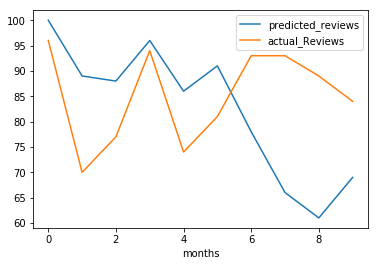

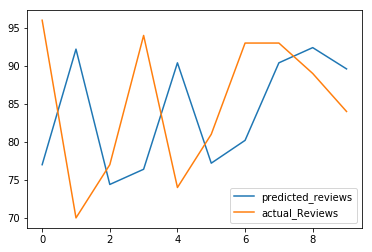

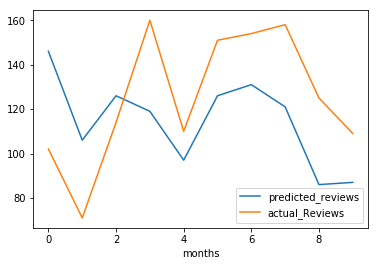

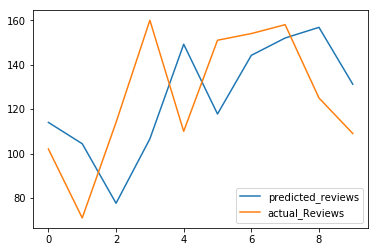

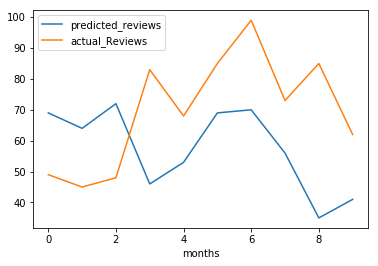

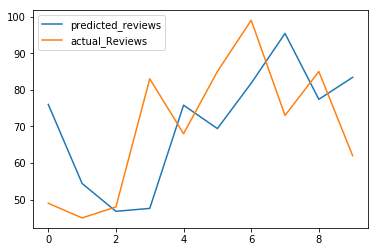

In [178]:
time_series()